In [1]:
%env DGLBACKEND=tensorflow
import dgl
import tensorflow as tf
import matplotlib.pyplot as plt


env: DGLBACKEND=tensorflow


2022-04-28 22:26:17.674466: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/manisb/opt/anaconda3/envs/ml-project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = dgl.data.CoraGraphDataset()

graph = dataset[0]
adj = graph.adjacency_matrix()

features = graph.ndata['feat']
labels = graph.ndata['label']

feature_len = features.shape[1]
node_len = features.shape[0]
label_len = tf.unique(labels)[0].shape[0]

random_cate_dist = tf.random.categorical(tf.math.log([[0.3, 0.05, 0.25, 0.4]]), node_len)

train_mask = random_cate_dist[0] == 1
val_mask = random_cate_dist[0] == 2
test_mask = random_cate_dist[0] == 3

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


**GCN Remormalization Layer and Model**

In [ ]:
class GCN_Layer(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim):
        super(GCN_Layer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.w = self.add_weight(shape=(self.input_dim, self.output_dim),
                               initializer=tf.keras.initializers.GlorotUniform(),
                               trainable=True)
    
    def call(self, adjacency_matrix, inputs):
        a_tilda = tf.sparse.add(adj, tf.sparse.eye(adj.shape[0]))
        d_tilda_sqrt_inv = tf.linalg.diag(
                 tf.math.pow(
                     tf.sparse.reduce_sum(a_tilda, axis=0), 
                     -0.5
                 )
            )
        a_d = tf.sparse.from_dense(
            tf.sparse.sparse_dense_matmul(
                d_tilda_sqrt_inv, 
                a_tilda, 
            )
        )
        a_cap = tf.sparse.from_dense(
            tf.sparse.sparse_dense_matmul(
                a_d, 
                d_tilda_sqrt_inv
            )
        )
        return tf.linalg.matmul(
            tf.sparse.sparse_dense_matmul(
                a_cap, 
                inputs
            ), 
            self.w
        )
    

class GCN_Model(tf.keras.Model):
    def __init__(self, imput_dim, output_dim):
        super(GCN_Model, self).__init__()
        self.layer1 = GCN_Layer(imput_dim, 10*16)
        self.layer2 = GCN_Layer(10*16, output_dim)

    def call(self, adjacency_matrix, inputs):
        x1 = tf.keras.activations.relu(self.layer1(adjacency_matrix, inputs))
        x2 = tf.keras.activations.softmax(self.layer2(adjacency_matrix, x1))
        return x2
    
    def compile(self, optimizer, loss, metric):
        self.optimizer = optimizer
        self.loss = loss
        self.metric = metric
        
    def fit(self, adj, features, labels, train_mask, val_mask, epochs):
        self.train_loss_results = []
        self.train_accuracy_results = []
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                y_pre = self(adj, features)
                loss_value = self.loss(y_true=labels[train_mask], y_pred=y_pre[train_mask])
            grads = tape.gradient(loss_value, self.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
            self._evaluate(features, labels, val_mask)

            self.train_loss_results.append(loss_value)
            self.train_accuracy_results.append(self.metric.result())

            print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch, loss_value, self.metric.result()))
            if (epoch > 10):
                change_in_loss_in_10_epochs = self.train_loss_results[-1] - tf.reduce_mean(self.train_loss_results[-(10+1):-1])
                if tf.math.abs(change_in_loss_in_10_epochs) < 0.001:
                    print("Early stopping...")
                    break
            
    def _evaluate(self, features, labels, val_mask):
        self.metric.reset_states()
        self.metric.update_state(
            labels[val_mask], 
            self(adj, features, training=True)[val_mask]
        )
    
    def test_on_batch(self, adj, features, labels, test_mask):
        test_accuracy = tf.keras.metrics.Accuracy()
        prediction = tf.argmax(self(adj, features, training=False), axis=1)
        test_accuracy(prediction[test_mask], labels[test_mask])
        self.test_accuracy = test_accuracy.result()
        return test_accuracy.result()
    


gcn_model = GCN_Model(features.shape[1], tf.unique(labels)[0].shape[0])

gcn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metric=tf.keras.metrics.SparseCategoricalAccuracy()
)

gcn_model.fit(adj, features, labels, train_mask, val_mask, 200)
acc = gcn_model.test_on_batch(adj, features, labels, test_mask)
print("Test set accuracy: {:.3%}".format(acc))

Epoch 000: Loss: 1.946, Accuracy: 46.755%
Epoch 001: Loss: 1.921, Accuracy: 46.018%
Epoch 002: Loss: 1.890, Accuracy: 46.755%
Epoch 003: Loss: 1.849, Accuracy: 46.903%
Epoch 004: Loss: 1.800, Accuracy: 47.345%
Epoch 005: Loss: 1.745, Accuracy: 47.788%
Epoch 006: Loss: 1.683, Accuracy: 48.230%
Epoch 007: Loss: 1.616, Accuracy: 49.410%
Epoch 008: Loss: 1.544, Accuracy: 49.853%
Epoch 009: Loss: 1.469, Accuracy: 50.295%
Epoch 010: Loss: 1.391, Accuracy: 51.475%
Epoch 011: Loss: 1.312, Accuracy: 53.687%
Epoch 012: Loss: 1.233, Accuracy: 55.900%
Epoch 013: Loss: 1.153, Accuracy: 57.227%
Epoch 014: Loss: 1.074, Accuracy: 59.292%
Epoch 015: Loss: 0.996, Accuracy: 60.914%
Epoch 016: Loss: 0.919, Accuracy: 64.159%
Epoch 017: Loss: 0.844, Accuracy: 65.339%
Epoch 018: Loss: 0.771, Accuracy: 67.404%
Epoch 019: Loss: 0.701, Accuracy: 70.059%
Epoch 020: Loss: 0.634, Accuracy: 72.124%
Epoch 021: Loss: 0.572, Accuracy: 73.599%
Epoch 022: Loss: 0.515, Accuracy: 75.221%
Epoch 023: Loss: 0.461, Accuracy: 

**GCN 1st order term only Layer and Model**

In [ ]:
class GCN_1st_order_Layer(GCN_Layer):
    def __init__(self, input_dim, output_dim):
        super(GCN_1st_order_Layer, self).__init__(input_dim, output_dim)
    
    def call(self, adjacency_matrix, inputs):
        d_sqrt_inv = tf.linalg.diag(
                 tf.math.pow(
                     tf.sparse.reduce_sum(adj, axis=0), 
                     -0.5
                 )
            )
        a_d = tf.sparse.from_dense(
            tf.sparse.sparse_dense_matmul(
                d_sqrt_inv, 
                adjacency_matrix, 
            )
        )
        a_cap = tf.sparse.from_dense(
            tf.sparse.sparse_dense_matmul(
                a_d, 
                d_sqrt_inv
            )
        )
        return tf.linalg.matmul(
            tf.sparse.sparse_dense_matmul(
                a_cap, 
                inputs
            ), 
            self.w
        )
    
class GCN_1st_order_Model(GCN_Model):
    def __init__(self, imput_dim, output_dim):
        super(GCN_1st_order_Model, self).__init__(imput_dim, output_dim)
        self.layer1 = GCN_1st_order_Layer(imput_dim, 10*16)
        self.layer2 = GCN_1st_order_Layer(10*16, output_dim)
        
        
        
        
gcn_1st_order_model = GCN_1st_order_Model(features.shape[1], tf.unique(labels)[0].shape[0])

gcn_1st_order_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metric=tf.keras.metrics.SparseCategoricalAccuracy()
)

gcn_1st_order_model.fit(adj, features, labels, train_mask, val_mask, 200)
acc = gcn_1st_order_model.test_on_batch(adj, features, labels, test_mask)
print("Test set accuracy: {:.3%}".format(acc))

**MLP Layer and Model**

In [ ]:
class Dense(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim):
        super(Dense, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.w = self.add_weight(shape=(self.input_dim, self.output_dim),
                               initializer=tf.keras.initializers.GlorotUniform(),
                               trainable=True)
    
    def call(self, inputs):
        return tf.linalg.matmul(inputs, self.w)
    

class MLP_Model(tf.keras.Model):
    def __init__(self, imput_dim, output_dim):
        super(MLP_Model, self).__init__()
        self.layer1 = Dense(imput_dim, 16)
        self.layer2 = Dense(16, output_dim)

    def call(self, inputs):
        x1 = tf.keras.activations.relu(self.layer1(inputs))
        x2 = tf.keras.activations.softmax(self.layer2(x1))
        return x2
    
        
    def compile(self, optimizer, loss, metric):
        self.optimizer = optimizer
        self.loss = loss
        self.metric = metric
        
    def fit(self, features, labels, train_mask, val_mask, epochs):
        self.train_loss_results = []
        self.train_accuracy_results = []
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                y_pre = self(features)
                loss_value = self.loss(y_true=labels[train_mask], y_pred=y_pre[train_mask])
            grads = tape.gradient(loss_value, self.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
            self._evaluate(features, labels, val_mask)

            self.train_loss_results.append(loss_value)
            self.train_accuracy_results.append(self.metric.result())

            print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch, loss_value, self.metric.result()))
            if (epoch > 10):
                change_in_loss_in_10_epochs = self.train_loss_results[-1] - tf.reduce_mean(self.train_loss_results[-(10+1):-1])
                if tf.math.abs(change_in_loss_in_10_epochs) < 0.001:
                    print("Early stopping...")
                    break

            
    def _evaluate(self, features, labels, val_mask):
        self.metric.reset_states()
        self.metric.update_state(
            labels[val_mask], 
            self(features, training=True)[val_mask]
        )
    
    def test_on_batch(self, features, labels, test_mask):
        test_accuracy = tf.keras.metrics.Accuracy()
        prediction = tf.argmax(self(features, training=False), axis=1)
        test_accuracy(prediction[test_mask], labels[test_mask])
        self.test_accuracy = test_accuracy.result()
        return test_accuracy.result()

    
mlp_model = MLP_Model(feature_len, label_len)

mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metric=tf.keras.metrics.SparseCategoricalAccuracy()
)

mlp_model.fit(features, labels, train_mask, val_mask, 200)
acc = mlp_model.test_on_batch(features, labels, test_mask)
print("Test set accuracy: {:.3%}".format(acc))

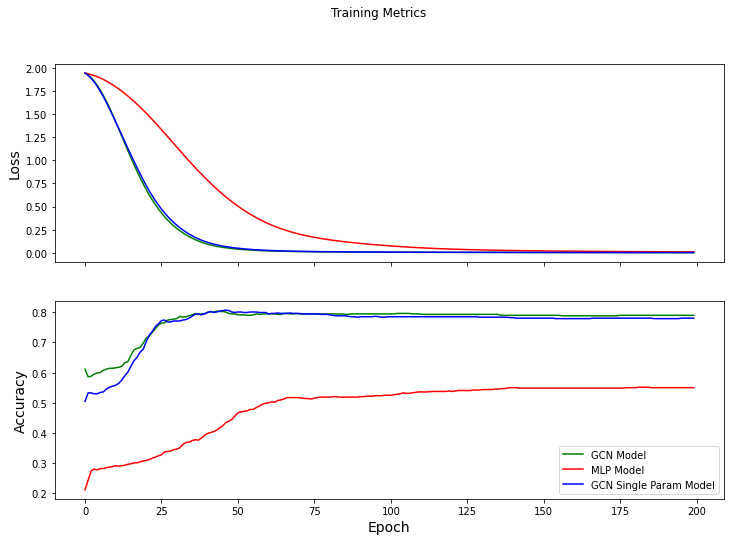

GCN Model Test set accuracy: 78.004%
GCN 1st Order Model Test set accuracy: 76.710%
MLP Model Test set accuracy: 52.311%


In [7]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(gcn_model.train_loss_results, color = 'green', label = 'GCN Model')
axes[0].plot(mlp_model.train_loss_results, color = 'red', label = 'MLP Model')
axes[0].plot(gcn_1st_order_model.train_loss_results, color = 'blue', label = 'GCN Single Param Model')

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].plot(gcn_model.train_accuracy_results, color = 'green', label = 'GCN Model')
axes[1].plot(mlp_model.train_accuracy_results, color = 'red', label = 'MLP Model')
axes[1].plot(gcn_1st_order_model.train_accuracy_results, color = 'blue', label = 'GCN Single Param Model')

axes[1].set_xlabel("Epoch", fontsize=14)

plt.legend()
plt.show()


print("GCN Model Test set accuracy: {:.3%}".format(gcn_model.test_accuracy))
print("GCN 1st Order Model Test set accuracy: {:.3%}".format(gcn_1st_order_model.test_accuracy))
print("MLP Model Test set accuracy: {:.3%}".format(mlp_model.test_accuracy))